In [1]:
from profiler.core import *

In [2]:
pf = Profiler(workers=2, verbose=False, tol=0.01, eps=0.1)

In [3]:
#pf.session.load_data(name='flights', src='file', fpath='/Users/zhihan/Documents/bart/data/clean_data/flights.csv', embedtxt=False)
pf.session.load_data(name='hospital', src='file', fpath='data/hospital.csv', embedtxt=True)


INFO:profiler.utility:[0.05037808418273926] Load Data start

INFO:profiler.dataset:inferred types of attributes: {
    "ProviderNumber": "text",
    "HospitalName": "text",
    "Address1": "text",
    "Address2": "categorical",
    "Address3": "categorical",
    "City": "text",
    "State": "categorical",
    "ZipCode": "text",
    "CountyName": "text",
    "PhoneNumber": "text",
    "HospitalType": "text",
    "HospitalOwner": "text",
    "EmergencyService": "categorical",
    "Condition": "text",
    "MeasureCode": "text",
    "MeasureName": "text",
    "Score": "text",
    "Sample": "text",
    "Stateavg": "text"
}
INFO:profiler.dataset:(possible types: numeric, categorical, text, date)
INFO:profiler.dataset:inferred operators of attributes: {'ProviderNumber': ['equal'], 'HospitalName': ['equal'], 'Address1': ['equal'], 'Address2': ['equal'], 'Address3': ['equal'], 'City': ['equal'], 'State': ['equal'], 'ZipCode': ['equal'], 'CountyName': ['equal'], 'PhoneNumber': ['equal'], 'Hospit

In [4]:
pf.session.change_dtypes(['ProviderNumber', 'ZipCode', 'PhoneNumber', 'State', 'EmergencyService','Score', 'Sample'], 
                            [CATEGORICAL, NUMERIC, CATEGORICAL, TEXT, TEXT, NUMERIC, NUMERIC],
                            [None, None, None, None, None, r'(\d+)%', r'(\d+)\spatients'])

INFO:profiler.dataset:updated types of ProviderNumber to 'categorical'
INFO:profiler.dataset:updated operators of ProviderNumber to ['equal']
INFO:profiler.dataset:updated types of ZipCode to 'numeric'
INFO:profiler.dataset:updated operators of ZipCode to ['equal']
INFO:profiler.dataset:updated types of PhoneNumber to 'categorical'
INFO:profiler.dataset:updated operators of PhoneNumber to ['equal']
INFO:profiler.dataset:updated types of State to 'text'
INFO:profiler.dataset:updated operators of State to ['equal']
INFO:profiler.dataset:updated types of EmergencyService to 'text'
INFO:profiler.dataset:updated operators of EmergencyService to ['equal']
INFO:profiler.dataset:updated types of Score to 'numeric'
INFO:profiler.dataset:updated operators of Score to ['equal']
INFO:profiler.dataset:updated types of Sample to 'numeric'
INFO:profiler.dataset:updated operators of Sample to ['equal']
INFO:profiler.dataset:updated inferred operators of attributes: {'ProviderNumber': ['equal'], 'Hospi

In [5]:
pf.session.load_embedding(save=True, path='data/hospital/', load=True)

INFO:profiler.utility:[0.15868902206420898] Load Embedding start

INFO:profiler.utility:[0.2013108730316162] Load Embedding execution time: 0.04262185096740723



In [6]:
pf.session.load_training_data()

INFO:profiler.utility:[0.20734715461730957] Create Training Data start

INFO:profiler.transformer:needs multiplier = 54 to bound the error in inv cov estimation <= 0.10000000
INFO:profiler.transformer:use multiplier = 54, and the bound is 0.00024939
INFO:profiler.transformer:Draw Pairs
100%|██████████| 19/19 [00:00<00:00, 194.56it/s]
INFO:profiler.transformer:Number of training samples: 56943
INFO:profiler.transformer:Computing Differences
INFO:profiler.transformer:estimated missing data probability in training data is 0.0283
INFO:profiler.utility:[0.7129058837890625] Create Training Data execution time: 0.5055587291717529



In [7]:
cov = pf.session.struct_engine.estimate_covariance()

In [8]:
from profiler.utility import visualize_heatmap
visualize_heatmap(cov)

<Figure size 1000x800 with 2 Axes>

In [9]:
from sklearn.covariance import graphical_lasso
_,inv = graphical_lasso(cov.values, alpha=0.05, max_iter=500)

INFO:profiler.learner:use threshold 0.0829


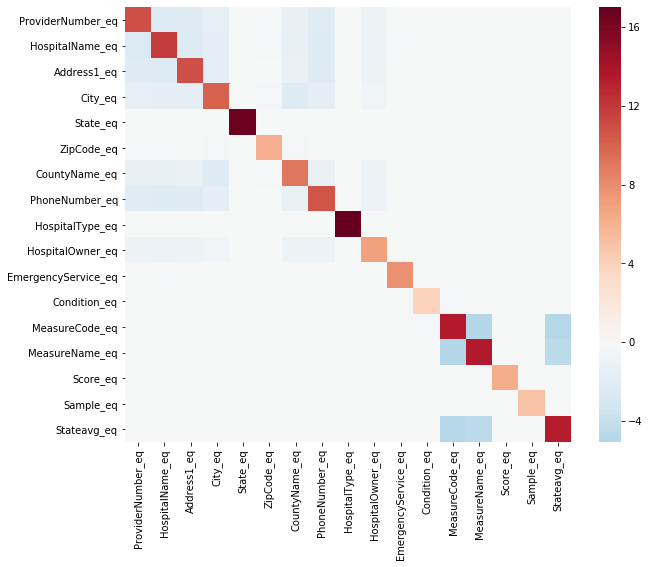

In [10]:
pf.session.struct_engine.param['sparsity'] = 0.05
pf.session.struct_engine.param['take_neg'] = True
pf.session.struct_engine.param['take_abs'] = False
inv_cov, est_cov = pf.session.struct_engine.estimate_inverse_covariance(cov.values)

HospitalName_eq,Address1_eq,City_eq,ZipCode_eq,CountyName_eq,PhoneNumber_eq,HospitalOwner_eq -> ProviderNumber_eq
ProviderNumber_eq,Address1_eq,City_eq,ZipCode_eq,CountyName_eq,PhoneNumber_eq,HospitalOwner_eq,EmergencyService_eq -> HospitalName_eq
ProviderNumber_eq,HospitalName_eq,City_eq,ZipCode_eq,CountyName_eq,PhoneNumber_eq,HospitalOwner_eq -> Address1_eq
ProviderNumber_eq,HospitalName_eq,Address1_eq,ZipCode_eq,CountyName_eq,PhoneNumber_eq,HospitalOwner_eq -> City_eq
ProviderNumber_eq,HospitalName_eq,Address1_eq,City_eq,CountyName_eq,PhoneNumber_eq -> ZipCode_eq
ProviderNumber_eq,HospitalName_eq,Address1_eq,City_eq,ZipCode_eq,PhoneNumber_eq,HospitalOwner_eq -> CountyName_eq
ProviderNumber_eq,HospitalName_eq,Address1_eq,City_eq,ZipCode_eq,CountyName_eq,HospitalOwner_eq -> PhoneNumber_eq
ProviderNumber_eq,HospitalName_eq,Address1_eq,City_eq,CountyName_eq,PhoneNumber_eq -> HospitalOwner_eq
HospitalName_eq -> EmergencyService_eq
MeasureCode_eq,MeasureName_eq -> Condition_eq
Condition_e

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


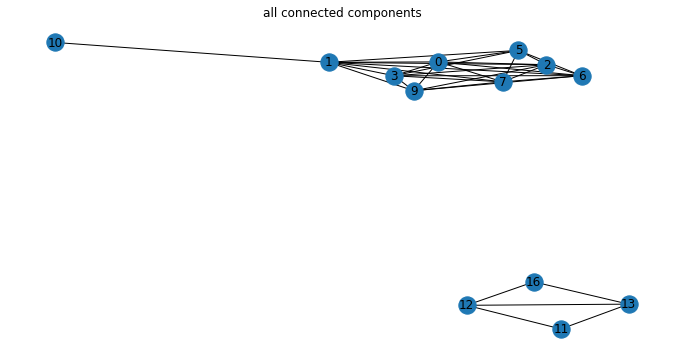

In [11]:
G = pf.session.struct_engine.recover_moral_graphs(inv_cov)
Gs = G.get_undirected_connected_components()

In [12]:
components = [list(g.idx_to_name.keys()) for g in Gs]

In [13]:
components[0]

[0, 1, 2, 3, 5, 6, 7, 9, 10]

In [14]:
from profiler.learner import StructureLearner
from sksparse.cholmod import cholesky, analyze
from itertools import permutations 
from scipy import sparse
from tqdm import tqdm
import pandas as pd

for c in components:
    U_hat = None
    # cholesky decomposition of invcov
    A = sparse.csr_matrix(inv_cov.values)
    factor = analyze(A)
    perm = factor.P()
    mat = inv_cov.iloc[perm, perm]
    A = sparse.csr_matrix(mat.values)
    factor = cholesky(A)
    U = factor.L_D()[0].toarray()
    U_hat = StructureLearner.get_df(U, inv_cov.columns.values[perm])    
    break

/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/ipykernel_launcher.py:12: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  if sys.path[0] == '':
/Users/zhihan/anaconda3/envs/fd37/lib/python3.7/site-packages/ipykernel_launcher.py:16: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  app.launch_new_instance()


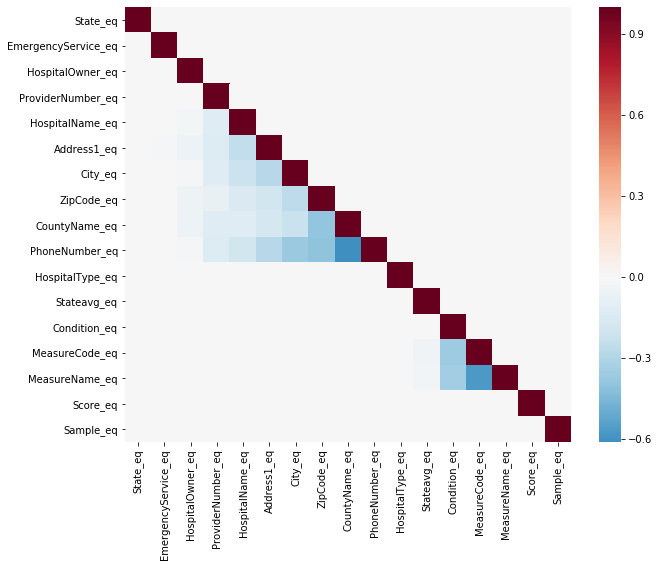

In [15]:
visualize_heatmap(U_hat)

In [16]:
training = pf.session.training_data.reset_index()
original = pf.session.ds.df.reset_index()
def validate_relation(left, right, data):
    stat = data.groupby(list(left)+[right])['index'].count()
    idx = list([1.0]*len(left))
    try:
        agree = stat.loc[tuple(idx + [1.0])] 
        disagree = stat.loc[tuple(idx + [0.0])] 
        ratio = agree / float(agree+disagree)
        return ratio, stat
    except:
        return 0, stat
def validate_fd(left, right, data):
    left = ["_".join(attr.split('_')[:-1]) for attr in left]
    right = "_".join(right.split('_')[:-1])

In [17]:
parent_sets = {}
for i, attr in enumerate(U_hat):
    columns = U_hat.columns.values[0:i]
    parents = columns[U_hat.iloc[i, 0:i] != 0]
    parent_sets[attr] = parents
    if len(parents) > 0:
        t_support, stat = validate_relation(parents, attr, training)
        #r_support, _ = validate_relation(parents, attr, original, suffix=False)
        print("{} -> {} ({})".format(",".join(parents), attr, t_support))
        # calculate 
        

HospitalOwner_eq,ProviderNumber_eq -> HospitalName_eq (0.9543436071181869)
EmergencyService_eq,HospitalOwner_eq,ProviderNumber_eq,HospitalName_eq -> Address1_eq (0.9400346996313165)
HospitalOwner_eq,ProviderNumber_eq,HospitalName_eq,Address1_eq -> City_eq (0.9311204841371722)
HospitalOwner_eq,ProviderNumber_eq,HospitalName_eq,Address1_eq,City_eq -> ZipCode_eq (0.9403237877653917)
HospitalOwner_eq,ProviderNumber_eq,HospitalName_eq,Address1_eq,City_eq,ZipCode_eq -> CountyName_eq (0.9305881367292225)
HospitalOwner_eq,ProviderNumber_eq,HospitalName_eq,Address1_eq,City_eq,ZipCode_eq,CountyName_eq -> PhoneNumber_eq (0.9403106009453073)
Stateavg_eq,Condition_eq -> MeasureCode_eq (0.9572895791583166)
Stateavg_eq,Condition_eq,MeasureCode_eq -> MeasureName_eq (0.9447860787648829)
